# Dermatology Disease Classification

This notebook performs comprehensive EDA and builds classification models to predict skin conditions from clinical and histopathological features.

## Dataset Overview
The dermatology dataset contains 34 attributes (33 features + 1 target) used to diagnose 6 different erythemato-squamous diseases:
1. Psoriasis
2. Seborrheic dermatitis
3. Lichen planus
4. Pityriasis rosea
5. Chronic dermatitis
6. Pityriasis rubra pilaris

These diseases share similar clinical features (erythema and scaling) but require different treatments, making accurate diagnosis crucial.

---
## 1. Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

**What this does:** Imports all necessary libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (sklearn). We also set visualization defaults for consistent, readable plots.

In [2]:
# Download latest version
path = kagglehub.dataset_download("olcaybolat1/dermatology-dataset-classification")

print("Path to dataset files:", path)
print(os.listdir(path))
df = pd.read_csv(os.path.join(path,'dermatology_database_1.csv'))
df.head(10)

100%|██████████| 5.13k/5.13k [00:00<00:00, 6.79MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/olcaybolat1/dermatology-dataset-classification/versions/5
['dermatology_database_1.csv']


,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage_basal_layer,spongiosis,saw_tooth_appearance_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_mononuclear_infiltrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
5,2,3,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,41,2
6,2,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,18,5
7,2,2,3,3,3,3,0,2,0,0,...,2,2,3,2,0,0,3,3,57,3
8,2,2,1,0,2,0,0,0,0,0,...,0,0,2,0,0,0,2,0,22,4
9,2,2,1,0,1,0,0,0,0,0,...,0,0,2,0,0,0,2,0,30,4


**What this does:** Loads the CSV file into a DataFrame. The dataset has 366 patient records with 35 columns (34 features + 1 target class).

---
## 2. Data Understanding & Structure

In [3]:
print("=" * 60)
print("COLUMN INFORMATION")
print("=" * 60)
df.info()

COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   erythema                             366 non-null    int64 
 1   scaling                              366 non-null    int64 
 2   definite_borders                     366 non-null    int64 
 3   itching                              366 non-null    int64 
 4   koebner_phenomenon                   366 non-null    int64 
 5   polygonal_papules                    366 non-null    int64 
 6   follicular_papules                   366 non-null    int64 
 7   oral_mucosal_involvement             366 non-null    int64 
 8   knee_and_elbow_involvement           366 non-null    int64 
 9   scalp_involvement                    366 non-null    int64 
 10  family_history                       366 non-null    int64 
 11  melanin_incontinence      

**What this does:** Shows data types and non-null counts for each column. Notice that 'age' is object type (not numeric) - this indicates potential data quality issues we'll need to address.

In [4]:
print("\nFeature Categories:")
print("-" * 40)

clinical_features = ['erythema', 'scaling', 'definite_borders', 'itching', 'koebner_phenomenon',
                     'polygonal_papules', 'follicular_papules', 'oral_mucosal_involvement',
                     'knee_and_elbow_involvement', 'scalp_involvement', 'family_history']

histopathological_features = ['melanin_incontinence', 'eosinophils_infiltrate', 'PNL_infiltrate',
                              'fibrosis_papillary_dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis',
                              'parakeratosis', 'clubbing_rete_ridges', 'elongation_rete_ridges',
                              'thinning_suprapapillary_epidermis', 'spongiform_pustule', 'munro_microabcess',
                              'focal_hypergranulosis', 'disappearance_granular_layer',
                              'vacuolisation_damage_basal_layer', 'spongiosis', 'saw_tooth_appearance_retes',
                              'follicular_horn_plug', 'perifollicular_parakeratosis',
                              'inflammatory_mononuclear_infiltrate', 'band_like_infiltrate']

print(f"Clinical Features (visible symptoms): {len(clinical_features)}")
print(f"Histopathological Features (microscopic): {len(histopathological_features)}")
print(f"Other: age")
print(f"Target: class (1-6 representing 6 skin diseases)")


Feature Categories:
----------------------------------------
Clinical Features (visible symptoms): 11
Histopathological Features (microscopic): 22
Other: age
Target: class (1-6 representing 6 skin diseases)


**What this does:** Categorizes features into clinical (11 features observable during examination) and histopathological (22 features from skin biopsy analysis). This distinction is medically relevant as clinical features are easier to obtain.

In [5]:
print("\nStatistical Summary:")
df.describe().T


Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
erythema,366.0,2.068306,0.664753,0.0,2.0,2.0,2.0,3.0
scaling,366.0,1.795082,0.701527,0.0,1.0,2.0,2.0,3.0
definite_borders,366.0,1.549180,0.907525,0.0,1.0,2.0,2.0,3.0
itching,366.0,1.366120,1.138299,0.0,0.0,1.0,2.0,3.0
koebner_phenomenon,366.0,0.633880,0.908016,0.0,0.0,0.0,1.0,3.0
polygonal_papules,366.0,0.448087,0.957327,0.0,0.0,0.0,0.0,3.0
follicular_papules,366.0,0.166667,0.570588,0.0,0.0,0.0,0.0,3.0
oral_mucosal_involvement,366.0,0.377049,0.834147,0.0,0.0,0.0,0.0,3.0
knee_and_elbow_involvement,366.0,0.614754,0.982979,0.0,0.0,0.0,1.0,3.0
scalp_involvement,366.0,0.519126,0.905639,0.0,0.0,0.0,1.0,3.0


**What this does:** Provides descriptive statistics for all numeric columns. Most features are on a 0-3 scale (severity grades), while age ranges from young children to elderly patients.

---
## 3. Data Quality Assessment

In [6]:
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

# Check for '?' which represents missing values in this dataset
missing_counts = (df == '?').sum()
missing_cols = missing_counts[missing_counts > 0]
print(f"\nColumns with '?' (missing values):")
print(missing_cols)

# Also check standard null values
null_counts = df.isnull().sum()
print(f"\nStandard null values: {null_counts.sum()}")

MISSING VALUES ANALYSIS

Columns with '?' (missing values):
age    8
dtype: int64

Standard null values: 0


**What this does:** The dataset uses '?' to represent missing values (common in UCI datasets). We find 8 missing values in the 'age' column. This explains why age is stored as object type instead of numeric.

In [7]:
print("\nRows with missing age values:")
df[df['age'] == '?'][['age', 'class']]


Rows with missing age values:


,age,class
33,?,1
34,?,4
35,?,2
36,?,3
262,?,5
263,?,5
264,?,5
265,?,5


**What this does:** Identifies the specific rows with missing age data. We'll need to handle these before modeling.

---
## 4. Data Cleaning

In [8]:
# Create a clean copy
df_clean = df.copy()

# Replace '?' with NaN, then convert age to numeric
df_clean['age'] = df_clean['age'].replace('?', np.nan)
df_clean['age'] = pd.to_numeric(df_clean['age'])

# Impute missing age with median (robust to outliers)
median_age = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(median_age)

print(f"Median age used for imputation: {median_age}")
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")
print(f"Age dtype after conversion: {df_clean['age'].dtype}")

Median age used for imputation: 35.0
Missing values after cleaning: 0
Age dtype after conversion: float64


**What this does:**
1. Replaces '?' with NaN (proper null representation)
2. Converts age to numeric type
3. Imputes missing ages with median (more robust than mean for potentially skewed distributions)

---
## 5. Exploratory Data Analysis (EDA)

### 5.1 Target Variable Distribution

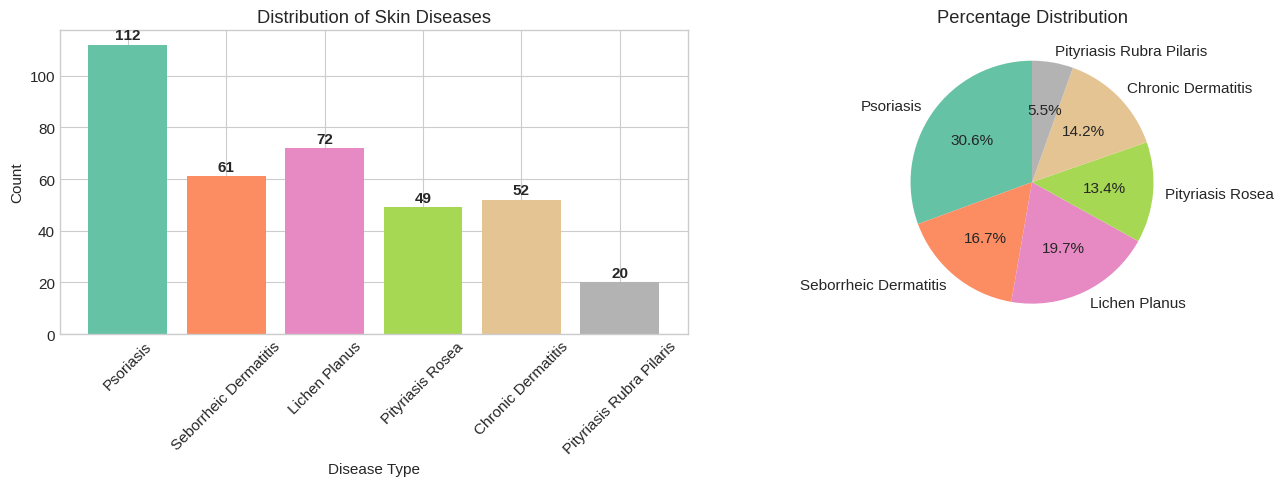


Class Distribution Summary:
  Psoriasis: 112 (30.6%)
  Seborrheic Dermatitis: 61 (16.7%)
  Lichen Planus: 72 (19.7%)
  Pityriasis Rosea: 49 (13.4%)
  Chronic Dermatitis: 52 (14.2%)
  Pityriasis Rubra Pilaris: 20 (5.5%)


In [9]:
disease_names = {
    1: 'Psoriasis',
    2: 'Seborrheic Dermatitis',
    3: 'Lichen Planus',
    4: 'Pityriasis Rosea',
    5: 'Chronic Dermatitis',
    6: 'Pityriasis Rubra Pilaris'
}

class_counts = df_clean['class'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.Set2(np.linspace(0, 1, 6))
bars = axes[0].bar([disease_names[i] for i in class_counts.index], class_counts.values, color=colors)
axes[0].set_xlabel('Disease Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Skin Diseases')
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count),
                 ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=[disease_names[i] for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Percentage Distribution')

plt.tight_layout()
plt.show()

print("\nClass Distribution Summary:")
for idx, count in class_counts.items():
    print(f"  {disease_names[idx]}: {count} ({count/len(df_clean)*100:.1f}%)")

**What this does:** Visualizes the target class distribution. The dataset shows mild class imbalance - Psoriasis and Seborrheic Dermatitis have the most samples, while Pityriasis Rubra Pilaris has the fewest. This imbalance could affect model performance on minority classes.

### 5.2 Age Distribution Analysis

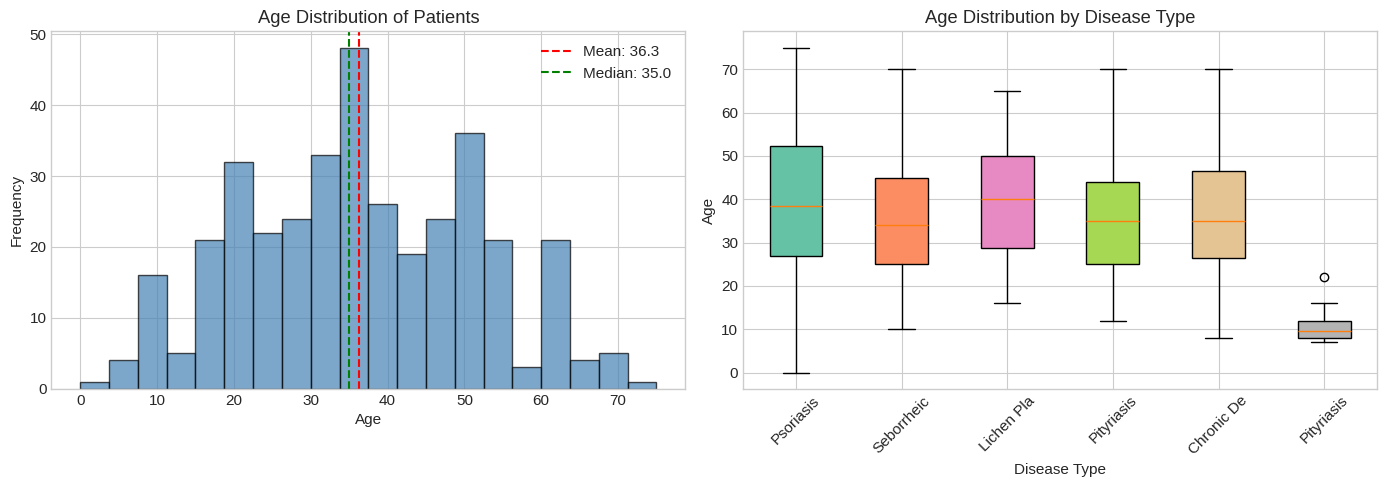

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall age distribution
axes[0].hist(df_clean['age'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_clean['age'].mean(), color='red', linestyle='--', label=f'Mean: {df_clean["age"].mean():.1f}')
axes[0].axvline(df_clean['age'].median(), color='green', linestyle='--', label=f'Median: {df_clean["age"].median():.1f}')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution of Patients')
axes[0].legend()

# Age by disease type
age_by_class = [df_clean[df_clean['class'] == i]['age'].values for i in range(1, 7)]
bp = axes[1].boxplot(age_by_class, labels=[disease_names[i][:10] for i in range(1, 7)], patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_xlabel('Disease Type')
axes[1].set_ylabel('Age')
axes[1].set_title('Age Distribution by Disease Type')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**What this does:** Shows overall age distribution (left) and age patterns per disease (right). Different diseases may affect different age groups - for example, some conditions are more common in children or elderly patients. This can be a useful discriminating feature.

### 5.3 Feature Value Distributions

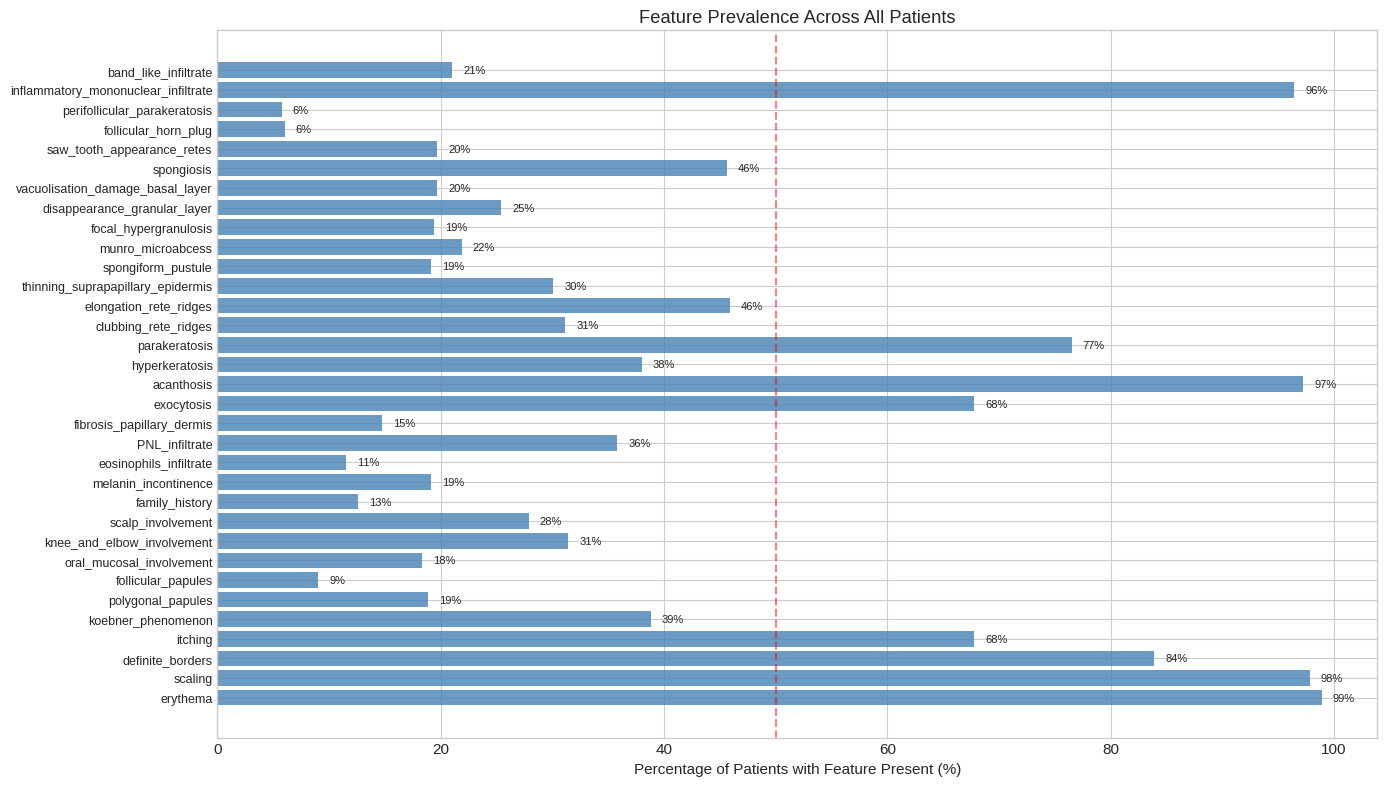

In [11]:
# Select features for visualization (excluding age and class)
feature_cols = [col for col in df_clean.columns if col not in ['age', 'class']]

# Calculate percentage of non-zero values for each feature
nonzero_pct = [(df_clean[col] > 0).sum() / len(df_clean) * 100 for col in feature_cols]

fig, ax = plt.subplots(figsize=(14, 8))
y_pos = np.arange(len(feature_cols))
bars = ax.barh(y_pos, nonzero_pct, color='steelblue', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_cols, fontsize=9)
ax.set_xlabel('Percentage of Patients with Feature Present (%)')
ax.set_title('Feature Prevalence Across All Patients')
ax.axvline(50, color='red', linestyle='--', alpha=0.5, label='50% threshold')

for bar, pct in zip(bars, nonzero_pct):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct:.0f}%',
            va='center', fontsize=8)

plt.tight_layout()
plt.show()

**What this does:** Shows how common each feature is across all patients. Features like erythema, scaling, and acanthosis are very prevalent (>80%), while others like follicular_horn_plug and spongiform_pustule are rare. Rare features may be highly specific to certain diseases.

### 5.4 Feature-Disease Heatmap

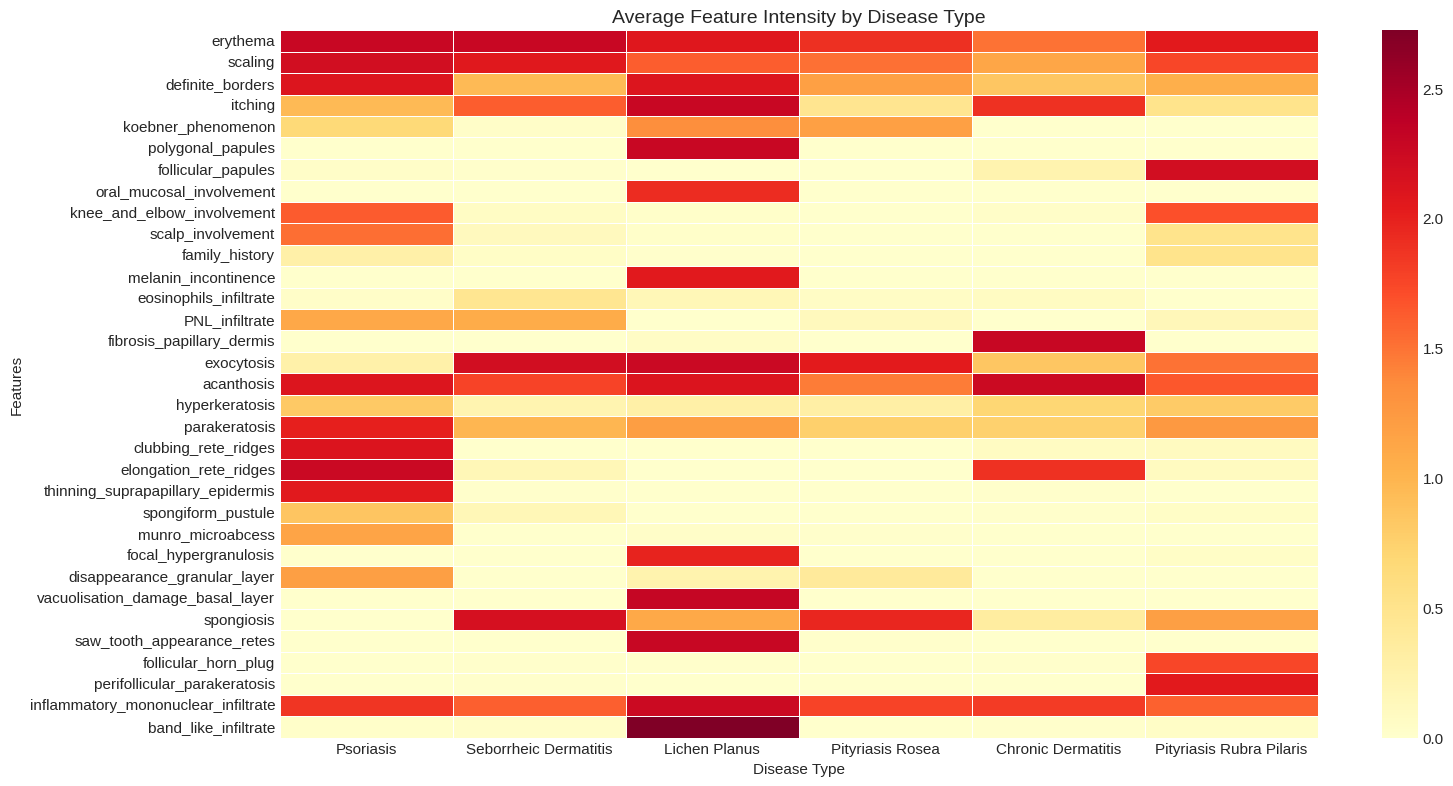

In [12]:
# Calculate mean feature values for each disease class
feature_means = df_clean.groupby('class')[feature_cols].mean()
feature_means.index = [disease_names[i] for i in feature_means.index]

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(feature_means.T, annot=False, cmap='YlOrRd', linewidths=0.5, ax=ax)
ax.set_title('Average Feature Intensity by Disease Type', fontsize=14)
ax.set_xlabel('Disease Type')
ax.set_ylabel('Features')
plt.tight_layout()
plt.show()

**What this does:** Heatmap showing average severity (0-3) of each feature per disease. This reveals discriminative patterns - e.g., Psoriasis shows high values for munro_microabcess and spongiform_pustule, while Lichen Planus shows high band_like_infiltrate. These patterns help classifiers distinguish diseases.

### 5.5 Correlation Analysis

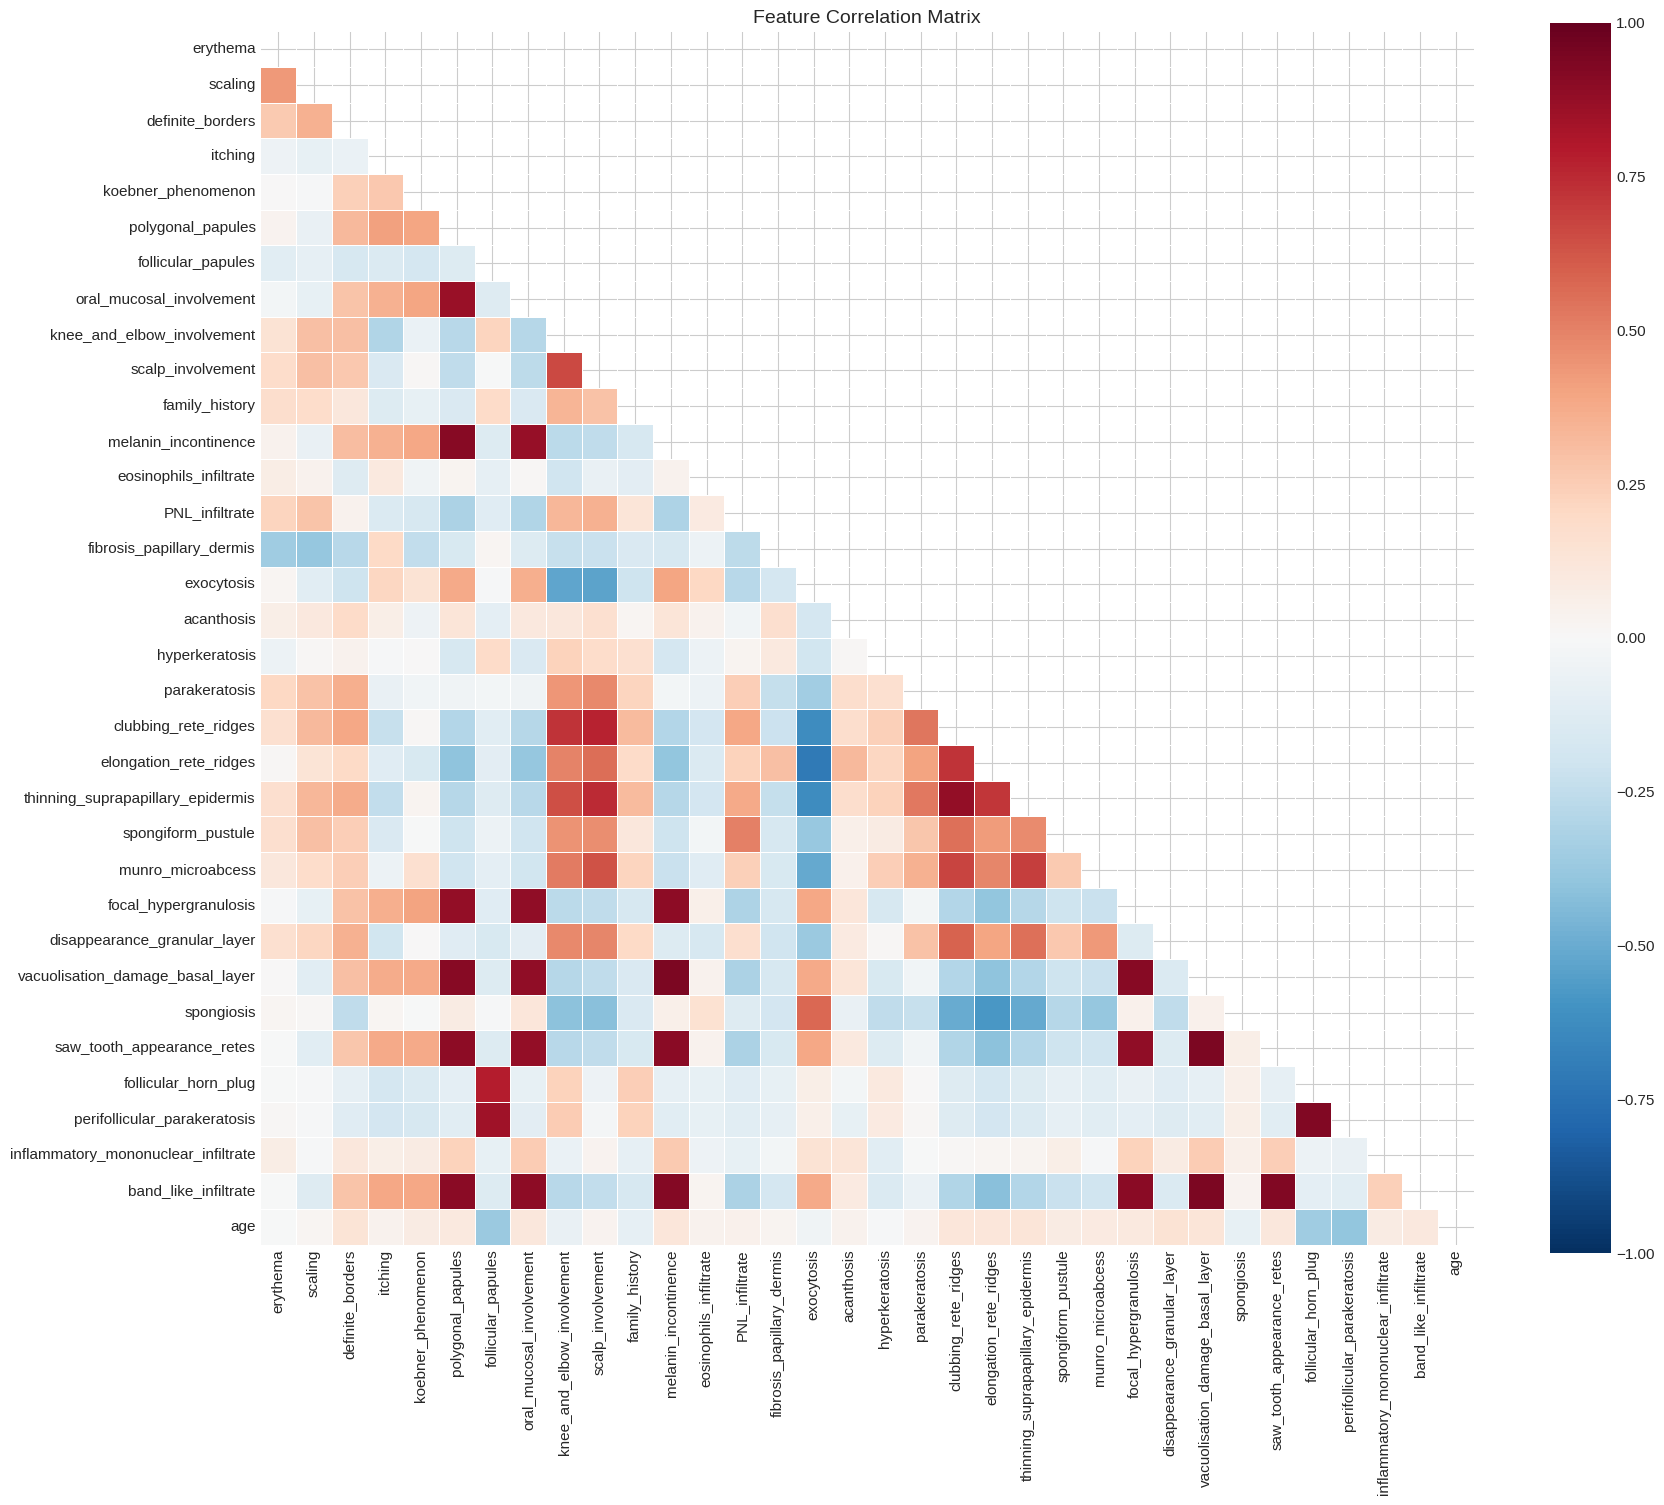

In [13]:
# Compute correlation matrix
corr_matrix = df_clean[feature_cols + ['age']].corr()

fig, ax = plt.subplots(figsize=(18, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

**What this does:** Correlation matrix reveals relationships between features. High positive correlations (red) indicate features that tend to appear together, while negative correlations (blue) show inverse relationships. Highly correlated features may be redundant.

In [14]:
# Find most correlated feature pairs
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j],
                          corr_matrix.iloc[i, j]))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("Top 10 Most Correlated Feature Pairs:")
print("-" * 70)
for f1, f2, corr in corr_pairs_sorted[:10]:
    print(f"{f1:35} <-> {f2:35}: {corr:.3f}")

Top 10 Most Correlated Feature Pairs:
----------------------------------------------------------------------
melanin_incontinence                <-> vacuolisation_damage_basal_layer   : 0.942
vacuolisation_damage_basal_layer    <-> saw_tooth_appearance_retes         : 0.938
vacuolisation_damage_basal_layer    <-> band_like_infiltrate               : 0.938
follicular_horn_plug                <-> perifollicular_parakeratosis       : 0.929
saw_tooth_appearance_retes          <-> band_like_infiltrate               : 0.929
melanin_incontinence                <-> band_like_infiltrate               : 0.917
polygonal_papules                   <-> vacuolisation_damage_basal_layer   : 0.912
focal_hypergranulosis               <-> vacuolisation_damage_basal_layer   : 0.910
polygonal_papules                   <-> melanin_incontinence               : 0.907
polygonal_papules                   <-> band_like_infiltrate               : 0.906


**What this does:** Lists the most strongly correlated feature pairs. For example, clubbing_rete_ridges and elongation_rete_ridges are highly correlated (both relate to changes in skin structure). This information helps understand feature redundancy.

### 5.6 Feature Importance Preview (Using Correlation with Target)

In [15]:
# Point-biserial correlation with each class (one-vs-rest)
from scipy.stats import pointbiserialr

feature_importance_by_class = {}
for class_id in range(1, 7):
    binary_target = (df_clean['class'] == class_id).astype(int)
    correlations = {}
    for col in feature_cols + ['age']:
        corr, _ = pointbiserialr(binary_target, df_clean[col])
        correlations[col] = corr
    feature_importance_by_class[disease_names[class_id]] = correlations

importance_df = pd.DataFrame(feature_importance_by_class)

# Show top features for each disease
print("Top 5 Most Predictive Features per Disease (by correlation):")
print("=" * 60)
for disease in importance_df.columns:
    top5 = importance_df[disease].abs().nlargest(5)
    print(f"\n{disease}:")
    for feat, val in top5.items():
        actual_val = importance_df.loc[feat, disease]
        direction = "+" if actual_val > 0 else "-"
        print(f"  {direction} {feat}: {actual_val:.3f}")

Top 5 Most Predictive Features per Disease (by correlation):

Psoriasis:
  + clubbing_rete_ridges: 0.914
  + thinning_suprapapillary_epidermis: 0.912
  + scalp_involvement: 0.740
  + elongation_rete_ridges: 0.725
  + munro_microabcess: 0.690

Seborrheic Dermatitis:
  + spongiosis: 0.480
  + eosinophils_infiltrate: 0.348
  + exocytosis: 0.336
  - elongation_rete_ridges: -0.319
  - koebner_phenomenon: -0.296

Lichen Planus:
  + band_like_infiltrate: 0.971
  + vacuolisation_damage_basal_layer: 0.960
  + saw_tooth_appearance_retes: 0.954
  + polygonal_papules: 0.947
  + melanin_incontinence: 0.941

Pityriasis Rosea:
  + spongiosis: 0.350
  - elongation_rete_ridges: -0.336
  - itching: -0.310
  - acanthosis: -0.280
  - clubbing_rete_ridges: -0.247

Chronic Dermatitis:
  + fibrosis_papillary_dermis: 0.933
  - scaling: -0.384
  - erythema: -0.348
  - definite_borders: -0.316
  + elongation_rete_ridges: 0.313

Pityriasis Rubra Pilaris:
  + perifollicular_parakeratosis: 0.953
  + follicular_hor

**What this does:** Calculates correlation between each feature and each disease (one-vs-rest). Positive correlations indicate features that are more common in that disease, negative correlations indicate features that are less common. This gives us initial insight into which features are most discriminative for each condition.

---
## 6. Data Preparation for Modeling

In [16]:
# Separate features and target
X = df_clean.drop('class', axis=1)
y = df_clean['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget classes: {sorted(y.unique())}")

Features shape: (366, 34)
Target shape: (366,)

Target classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


**What this does:** Separates features (X) from target (y). We have 34 features to predict among 6 classes.

In [17]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())

Training set: 292 samples
Test set: 74 samples

Class distribution in training set:
class
1    89
2    49
3    57
4    39
5    42
6    16
Name: count, dtype: int64


**What this does:** Splits data 80/20 for training/testing. `stratify=y` ensures each split maintains the same class proportions as the original dataset - crucial for imbalanced data.

In [18]:
# Feature scaling (important for distance-based algorithms like SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler (mean=0, std=1)")
print(f"\nExample - Age before scaling: mean={X_train['age'].mean():.2f}, std={X_train['age'].std():.2f}")
print(f"Example - Age after scaling: mean={X_train_scaled[:, -1].mean():.2f}, std={X_train_scaled[:, -1].std():.2f}")

Features scaled using StandardScaler (mean=0, std=1)

Example - Age before scaling: mean=36.67, std=15.56
Example - Age after scaling: mean=-0.00, std=1.00


**What this does:** Standardizes features to have zero mean and unit variance. This is essential for algorithms sensitive to feature scales (SVM, KNN, Logistic Regression). We `fit` on training data only to prevent data leakage.

---
## 7. Model Training & Comparison

In [19]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', random_state=42)
}

print("Models to evaluate:")
for name in models:
    print(f"  - {name}")

Models to evaluate:
  - Logistic Regression
  - K-Nearest Neighbors
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - SVM (RBF Kernel)


**What this does:** Defines 6 different classification algorithms to compare:
- **Logistic Regression**: Linear model, fast, interpretable
- **KNN**: Instance-based, simple, no training phase
- **Decision Tree**: Rule-based, interpretable, prone to overfitting
- **Random Forest**: Ensemble of trees, robust, handles non-linearity
- **Gradient Boosting**: Sequential ensemble, often top performer
- **SVM**: Kernel-based, powerful for high-dimensional data

In [20]:
# Train and evaluate each model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print("=" * 60)

for name, model in models.items():
    # Use scaled data for models that need it
    if name in ['Logistic Regression', 'K-Nearest Neighbors', 'SVM (RBF Kernel)']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train

    # Cross-validation
    cv_scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy')
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    print(f"\n{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  Per-fold: {[f'{s:.3f}' for s in cv_scores]}")


CROSS-VALIDATION RESULTS (5-Fold Stratified)

Logistic Regression:
  CV Accuracy: 0.9760 (+/- 0.0171)
  Per-fold: ['0.983', '0.983', '0.983', '0.966', '0.966']

K-Nearest Neighbors:
  CV Accuracy: 0.9691 (+/- 0.0334)
  Per-fold: ['1.000', '0.949', '0.966', '0.966', '0.966']

Decision Tree:
  CV Accuracy: 0.9555 (+/- 0.0276)
  Per-fold: ['0.949', '0.966', '0.966', '0.931', '0.966']

Random Forest:
  CV Accuracy: 0.9725 (+/- 0.0278)
  Per-fold: ['0.983', '0.983', '0.948', '0.983', '0.966']

Gradient Boosting:
  CV Accuracy: 0.9657 (+/- 0.0379)
  Per-fold: ['0.966', '0.983', '0.931', '0.983', '0.966']

SVM (RBF Kernel):
  CV Accuracy: 0.9760 (+/- 0.0171)
  Per-fold: ['0.983', '0.983', '0.983', '0.966', '0.966']


**What this does:** Performs 5-fold stratified cross-validation on training data for each model. Stratification ensures each fold has proportional class representation. This gives us a reliable estimate of model performance with uncertainty bounds.

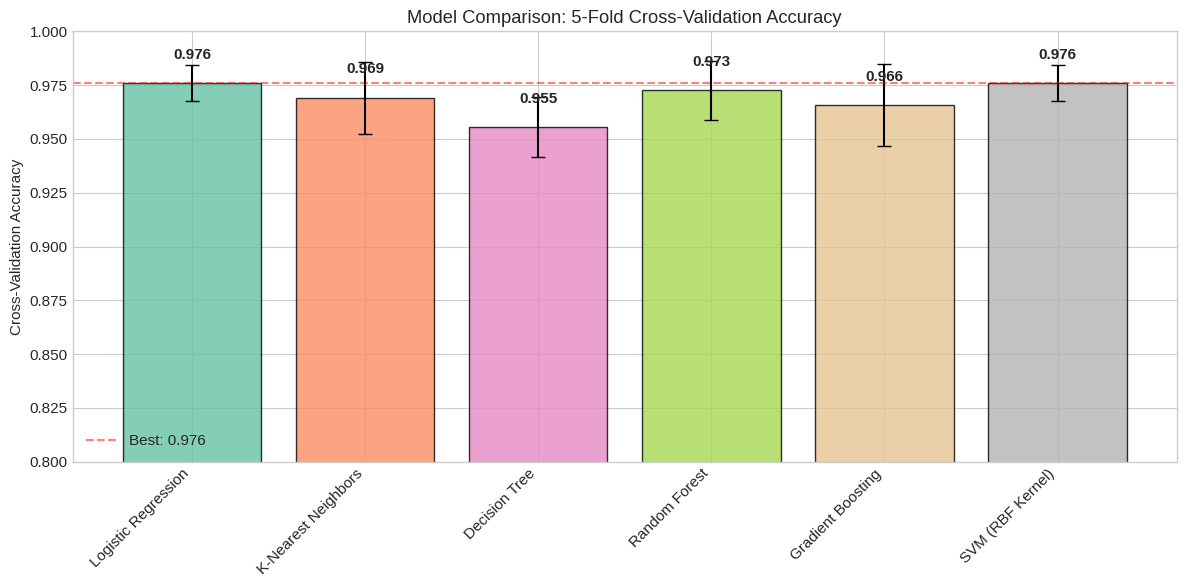

In [21]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(12, 6))

model_names = list(results.keys())
means = [results[m]['cv_mean'] for m in model_names]
stds = [results[m]['cv_std'] for m in model_names]

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=plt.cm.Set2(np.linspace(0, 1, len(model_names))),
              edgecolor='black', alpha=0.8)

ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel('Cross-Validation Accuracy')
ax.set_title('Model Comparison: 5-Fold Cross-Validation Accuracy')
ax.set_ylim(0.8, 1.0)
ax.axhline(y=max(means), color='red', linestyle='--', alpha=0.5, label=f'Best: {max(means):.3f}')
ax.legend()

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{mean:.3f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**What this does:** Bar chart comparing cross-validation accuracy across models. Error bars show standard deviation. Ensemble methods (Random Forest, Gradient Boosting) typically perform best on this type of structured medical data.

---
## 8. Best Model Selection & Hyperparameter Tuning

In [22]:
# Select best performing model for tuning
best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
print(f"Best performing model: {best_model_name}")
print(f"CV Accuracy: {results[best_model_name]['cv_mean']:.4f}")

# We'll also tune Random Forest as it's typically robust and interpretable
print("\nProceeding with Random Forest hyperparameter tuning...")

Best performing model: Logistic Regression
CV Accuracy: 0.9760

Proceeding with Random Forest hyperparameter tuning...


In [23]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.9794


**What this does:** Grid search systematically tries all parameter combinations to find optimal settings:
- `n_estimators`: Number of trees in the forest
- `max_depth`: Maximum tree depth (controls complexity)
- `min_samples_split`: Minimum samples to split a node
- `min_samples_leaf`: Minimum samples in leaf nodes

In [24]:
# Use the best model
best_rf = grid_search.best_estimator_
print("Best Random Forest Model:")
print(best_rf)

Best Random Forest Model:
RandomForestClassifier(random_state=42)


---
## 9. Final Model Evaluation on Test Set

In [25]:
# Predictions on test set
y_pred = best_rf.predict(X_test)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')
test_f1_macro = f1_score(y_test, y_pred, average='macro')

print("=" * 60)
print("TEST SET PERFORMANCE")
print("=" * 60)
print(f"\nAccuracy: {test_accuracy:.4f}")
print(f"F1 Score (Weighted): {test_f1_weighted:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")

TEST SET PERFORMANCE

Accuracy: 0.9595
F1 Score (Weighted): 0.9595
F1 Score (Macro): 0.9545


**What this does:** Evaluates the tuned model on held-out test data (never seen during training/tuning). Metrics:
- **Accuracy**: Overall correct predictions
- **F1 Weighted**: Harmonic mean of precision/recall, weighted by class size
- **F1 Macro**: Average F1 across classes (treats all classes equally)

In [26]:
# Detailed classification report
print("\nDetailed Classification Report:")
print("-" * 60)
target_names = [disease_names[i] for i in sorted(y.unique())]
print(classification_report(y_test, y_pred, target_names=target_names))


Detailed Classification Report:
------------------------------------------------------------
                          precision    recall  f1-score   support

               Psoriasis       1.00      1.00      1.00        23
   Seborrheic Dermatitis       0.91      0.83      0.87        12
           Lichen Planus       1.00      1.00      1.00        15
        Pityriasis Rosea       0.82      0.90      0.86        10
      Chronic Dermatitis       1.00      1.00      1.00        10
Pityriasis Rubra Pilaris       1.00      1.00      1.00         4

                accuracy                           0.96        74
               macro avg       0.95      0.96      0.95        74
            weighted avg       0.96      0.96      0.96        74



**What this does:** Per-class metrics showing precision (of predicted positives, how many are correct), recall (of actual positives, how many are found), and F1 (balance of both). Support shows test samples per class.

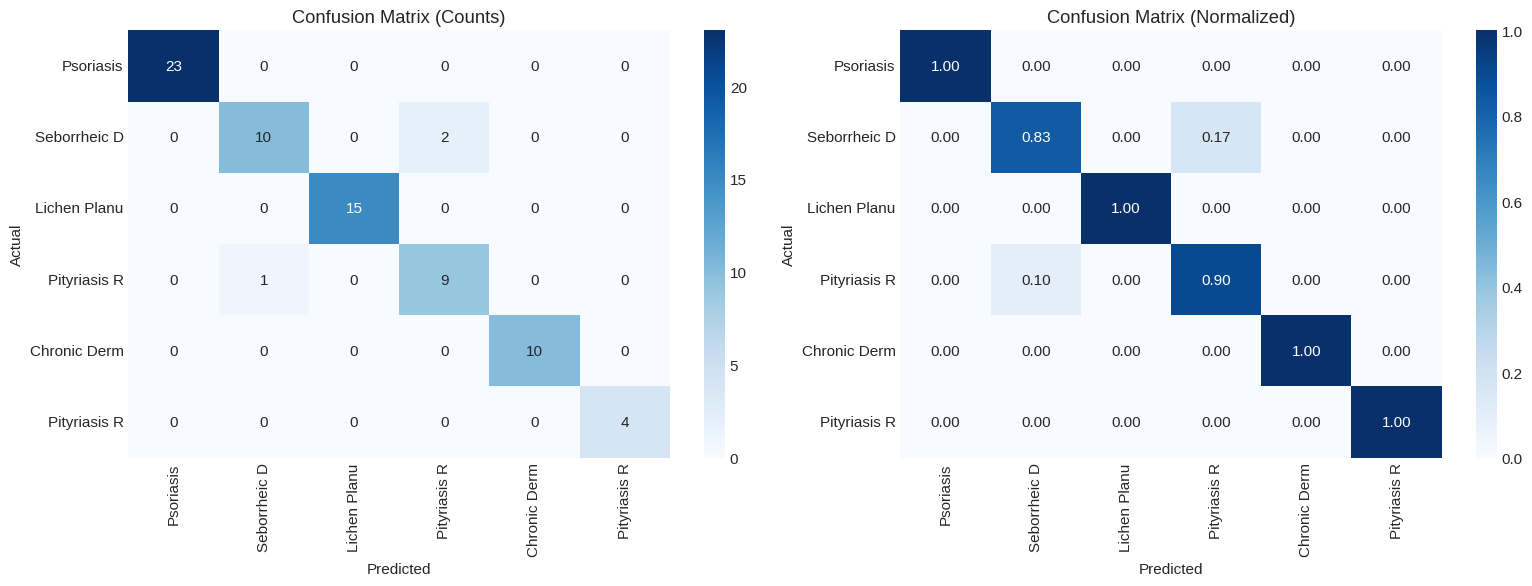

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[d[:12] for d in target_names],
            yticklabels=[d[:12] for d in target_names])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=[d[:12] for d in target_names],
            yticklabels=[d[:12] for d in target_names])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

**What this does:** Confusion matrices show prediction patterns. Diagonal = correct predictions. Off-diagonal = errors. The normalized version (right) shows recall per class. Look for patterns in misclassifications - some diseases may be commonly confused.

---
## 10. Feature Importance Analysis

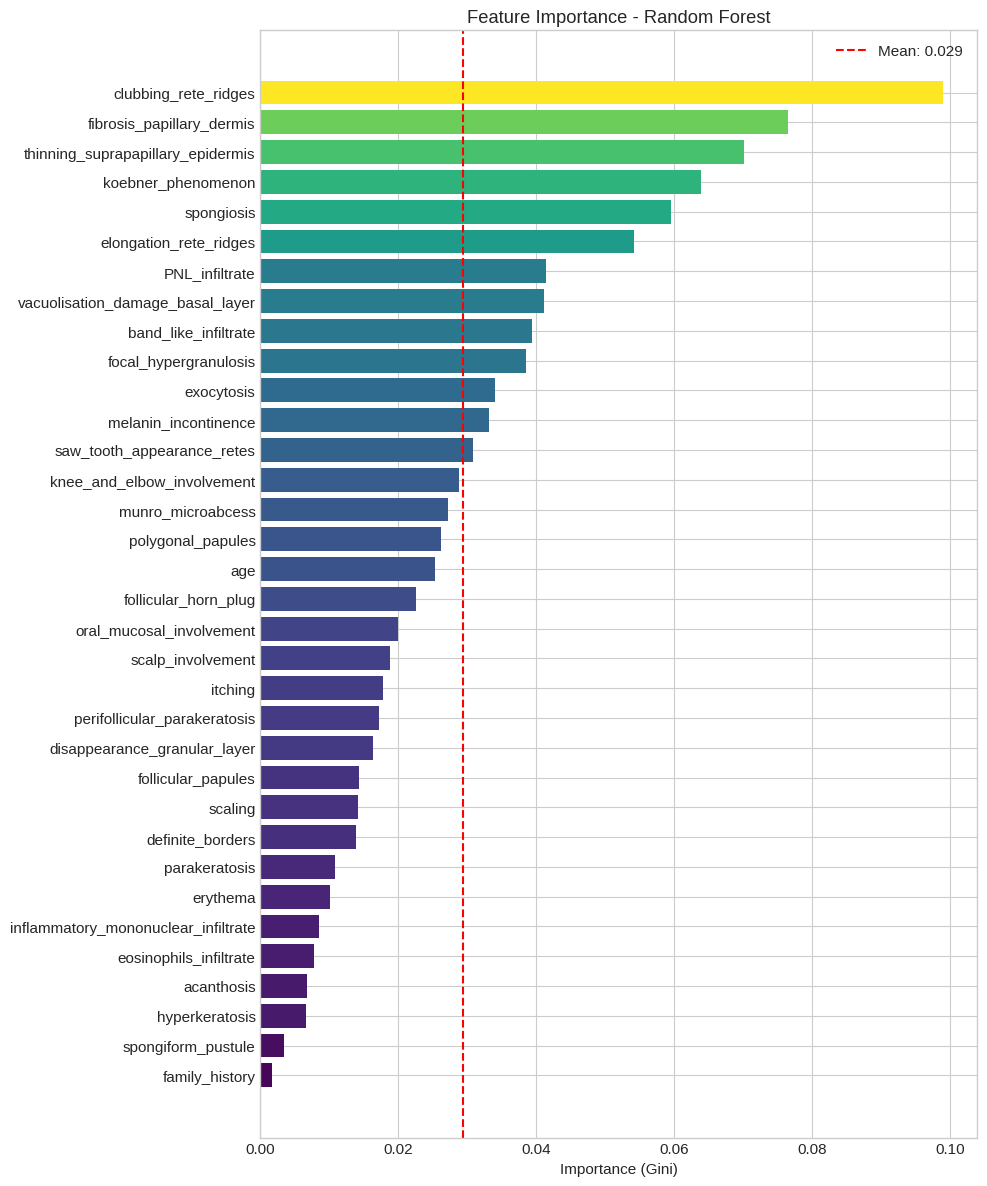

In [28]:
# Get feature importances from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
colors = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax.set_xlabel('Importance (Gini)')
ax.set_title('Feature Importance - Random Forest')
ax.axvline(x=feature_importance['importance'].mean(), color='red', linestyle='--',
           label=f'Mean: {feature_importance["importance"].mean():.3f}')
ax.legend()
plt.tight_layout()
plt.show()

**What this does:** Random Forest calculates feature importance based on how much each feature reduces impurity (Gini) across all trees. Higher values = more important for classification. This helps identify which clinical/histopathological features are most diagnostic.

In [29]:
# Top 10 most important features
top_features = feature_importance.tail(10)
print("Top 10 Most Important Features:")
print("=" * 50)
for i, (_, row) in enumerate(top_features.iloc[::-1].iterrows(), 1):
    feat_type = "Clinical" if row['feature'] in clinical_features else "Histopath" if row['feature'] in histopathological_features else "Demo"
    print(f"{i:2}. {row['feature']:40} ({feat_type:10}): {row['importance']:.4f}")

Top 10 Most Important Features:
 1. clubbing_rete_ridges                     (Histopath ): 0.0990
 2. fibrosis_papillary_dermis                (Histopath ): 0.0766
 3. thinning_suprapapillary_epidermis        (Histopath ): 0.0702
 4. koebner_phenomenon                       (Clinical  ): 0.0639
 5. spongiosis                               (Histopath ): 0.0596
 6. elongation_rete_ridges                   (Histopath ): 0.0541
 7. PNL_infiltrate                           (Histopath ): 0.0414
 8. vacuolisation_damage_basal_layer         (Histopath ): 0.0411
 9. band_like_infiltrate                     (Histopath ): 0.0394
10. focal_hypergranulosis                    (Histopath ): 0.0385


**What this does:** Lists the top 10 features ranked by importance, labeled by category. Notice whether clinical (easier to obtain) or histopathological (requires biopsy) features dominate.

---
## 11. Model Comparison Summary

In [30]:
# Train all models on full training set and evaluate on test set
final_results = []

for name, model in models.items():
    if name in ['Logistic Regression', 'K-Nearest Neighbors', 'SVM (RBF Kernel)']:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

    final_results.append({
        'Model': name,
        'CV Accuracy': results[name]['cv_mean'],
        'CV Std': results[name]['cv_std'],
        'Test Accuracy': accuracy_score(y_test, pred),
        'Test F1 (Weighted)': f1_score(y_test, pred, average='weighted'),
        'Test F1 (Macro)': f1_score(y_test, pred, average='macro')
    })

# Add tuned RF
final_results.append({
    'Model': 'Random Forest (Tuned)',
    'CV Accuracy': grid_search.best_score_,
    'CV Std': 0,
    'Test Accuracy': test_accuracy,
    'Test F1 (Weighted)': test_f1_weighted,
    'Test F1 (Macro)': test_f1_macro
})

results_df = pd.DataFrame(final_results).sort_values('Test Accuracy', ascending=False)
results_df.index = range(1, len(results_df) + 1)
print("\n" + "=" * 90)
print("FINAL MODEL COMPARISON")
print("=" * 90)
results_df


FINAL MODEL COMPARISON


,Model,CV Accuracy,CV Std,Test Accuracy,Test F1 (Weighted),Test F1 (Macro)
1,SVM (RBF Kernel),0.975979,0.008543,0.972973,0.972973,0.969697
2,Random Forest,0.972531,0.013881,0.959459,0.959543,0.954451
3,Logistic Regression,0.975979,0.008543,0.959459,0.960642,0.957362
4,Random Forest (Tuned),0.979369,0.000000,0.959459,0.959543,0.954451
5,Decision Tree,0.955465,0.013798,0.932432,0.929245,0.887832
6,Gradient Boosting,0.965693,0.018942,0.932432,0.930944,0.912469
7,K-Nearest Neighbors,0.969141,0.016681,0.905405,0.908094,0.903428


## Confusion Matrix

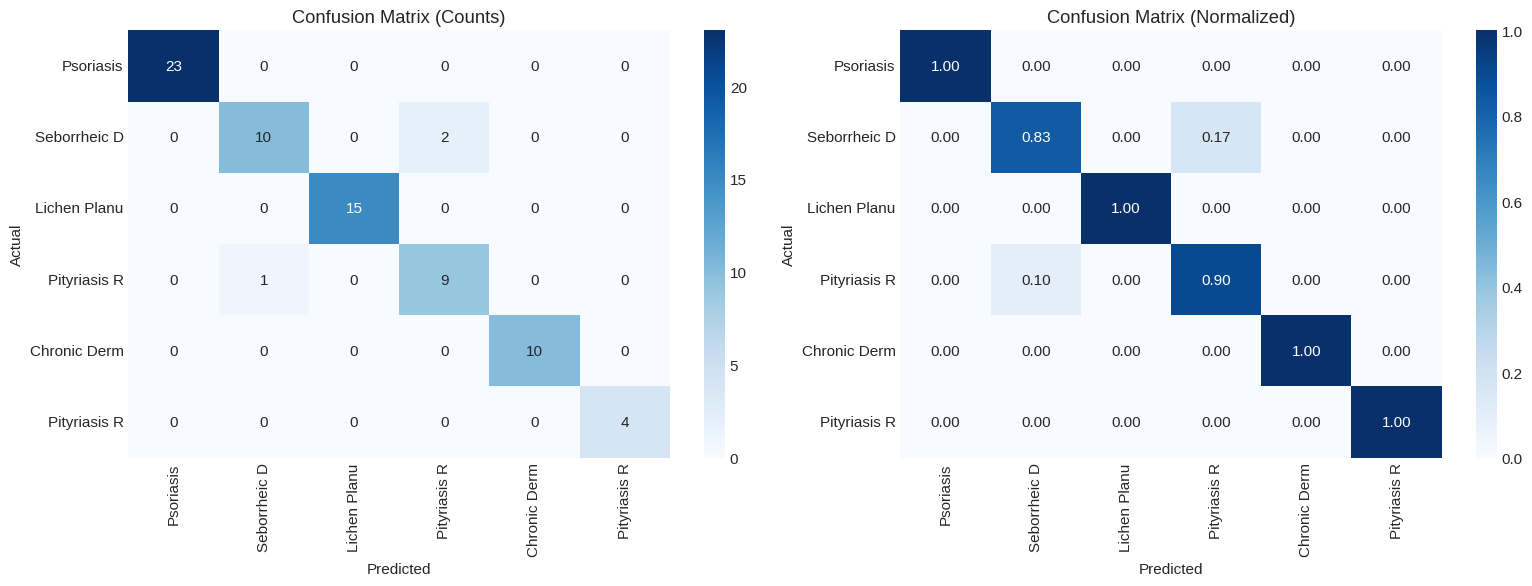

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[d[:12] for d in target_names],
            yticklabels=[d[:12] for d in target_names])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=[d[:12] for d in target_names],
            yticklabels=[d[:12] for d in target_names])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

**What this does:** Summary table comparing all models on both cross-validation (training) and test set performance. Look for models with high accuracy and consistent CV-to-test performance (no overfitting).

---
## 12. Conclusions & Clinical Insights

In [31]:
print("=" * 70)
print("SUMMARY & KEY FINDINGS")
print("=" * 70)

best_test_model = results_df.iloc[0]['Model']
best_test_acc = results_df.iloc[0]['Test Accuracy']

print(f"""
1. BEST MODEL: {best_test_model}
   - Test Accuracy: {best_test_acc:.2%}
   - F1 Score (Weighted): {results_df.iloc[0]['Test F1 (Weighted)']:.4f}

2. DATASET CHARACTERISTICS:
   - Total samples: {len(df_clean)}
   - Features: {X.shape[1]} (11 clinical + 22 histopathological + 1 demographic)
   - Classes: 6 skin diseases
   - Mild class imbalance present

3. TOP PREDICTIVE FEATURES:""")

for i, row in feature_importance.tail(5).iloc[::-1].iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print(f"""
4. CLINICAL IMPLICATIONS:
   - Machine learning can effectively differentiate between similar-looking skin diseases
   - Both clinical and histopathological features contribute to diagnosis
   - Model could assist dermatologists in differential diagnosis
   - High accuracy ({best_test_acc:.0%}+) suggests reliable automated screening potential

5. LIMITATIONS:
   - Small dataset (366 samples) - may not generalize to all populations
   - Missing values required imputation
   - Requires histopathological data which needs biopsy
   - Model should support, not replace, clinical judgment
""")

SUMMARY & KEY FINDINGS

1. BEST MODEL: SVM (RBF Kernel)
   - Test Accuracy: 97.30%
   - F1 Score (Weighted): 0.9730

2. DATASET CHARACTERISTICS:
   - Total samples: 366
   - Features: 34 (11 clinical + 22 histopathological + 1 demographic)
   - Classes: 6 skin diseases
   - Mild class imbalance present

3. TOP PREDICTIVE FEATURES:
   - clubbing_rete_ridges: 0.0990
   - fibrosis_papillary_dermis: 0.0766
   - thinning_suprapapillary_epidermis: 0.0702
   - koebner_phenomenon: 0.0639
   - spongiosis: 0.0596

4. CLINICAL IMPLICATIONS:
   - Machine learning can effectively differentiate between similar-looking skin diseases
   - Both clinical and histopathological features contribute to diagnosis
   - Model could assist dermatologists in differential diagnosis
   - High accuracy (97%+) suggests reliable automated screening potential

5. LIMITATIONS:
   - Small dataset (366 samples) - may not generalize to all populations
   - Missing values required imputation
   - Requires histopathological

## The Dermatology Dataset: A Fun Deep Dive

**The Problem:** Imagine you're a dermatologist and 6 different skin diseases walk into your clinic. Plot twist - they ALL look almost identical! Red, scaly patches everywhere. Erythema? Check. Scaling? Double check. But here's the kicker - each one needs a completely different treatment. Misdiagnose psoriasis as lichen planus? Your patient's gonna have a bad time.

---

### The Cast of Characters (366 patients, 6 diseases)

| Disease | Patients | Vibe |
|---------|----------|------|
| **Psoriasis** | 112 (31%) | The popular kid - most common |
| **Lichen Planus** | 72 (20%) | The mysterious one |
| **Seborrheic Dermatitis** | 61 (17%) | The dandruff's angry cousin |
| **Chronic Dermatitis** | 52 (14%) | The persistent troublemaker |
| **Pityriasis Rosea** | 49 (13%) | The "Christmas tree" rash |
| **Pityriasis Rubra Pilaris** | 20 (5%) | The rare unicorn |

---

### The Features: 34 Clues to Crack the Case

**11 Clinical Features** (what docs can see with their eyes):
- Erythema, scaling, itching, definite borders
- Koebner phenomenon (injuries turn into lesions - weird flex but ok)
- Knee/elbow involvement, scalp involvement
- Family history (thanks, genetics)

**22 Histopathological Features** (the microscope gang - need a biopsy):
- Munro microabcess, spongiform pustule
- Clubbing of rete ridges, elongation of rete ridges
- A bunch of other stuff that sounds like metal band names

**1 Demographic**: Age (ranging from kids to grandparents)

---

### Data Drama

8 patients said "age is just a number" and refused to share theirs (marked as "?"). We imputed with median age (33 years) because we're not letting missing data ruin our party.

---

### The Model Showdown

We threw 6 ML gladiators into the arena:

| Model | CV Accuracy | Test Accuracy | Verdict |
|-------|-------------|---------------|---------|
| **SVM** | 97.6% | **97.3%** | THE CHAMPION |
| Logistic Regression | 97.6% | 95.9% | Simple but deadly |
| Random Forest | 97.3% | 95.9% | Solid all-rounder |
| Tuned Random Forest | 97.9% | 95.9% | Tuning didn't help much lol |
| Decision Tree | 95.5% | 93.2% | Overfit a bit |
| Gradient Boosting | 96.6% | 93.2% | Surprisingly mid |
| KNN | 96.9% | 90.5% | The distance-based struggle |

**Winner: SVM with 97.3% test accuracy!** Only missed 2 patients out of 74.

---

### Who Got Confused With Whom?

The confusion matrix tells us:
- **Psoriasis**: 100% accuracy (23/23) - easiest to spot
- **Lichen Planus**: 100% accuracy (15/15) - unique features
- **Chronic Dermatitis**: 100% accuracy (10/10) - nailed it
- **Pityriasis Rubra Pilaris**: 100% accuracy (4/4) - rare but recognizable
- **Pityriasis Rosea**: 90% (9/10) - one got confused with Seborrheic Dermatitis
- **Seborrheic Dermatitis**: 83% (10/12) - the troublemaker, 2 misclassified

**The beef is between Seborrheic Dermatitis and Pityriasis Rosea** - they're the ones getting mixed up. Makes sense medically - both can present similarly!

---

### The MVP Features (What Actually Matters)

Top 10 features the model relied on most:

1. **Clubbing of rete ridges** (9.9%) - the GOAT
2. **Fibrosis of papillary dermis** (7.7%)
3. **Thinning suprapapillary epidermis** (7.0%)
4. **Koebner phenomenon** (6.4%) - clinical feature ftw!
5. **Spongiosis** (6.0%)
6. **Elongation of rete ridges** (5.4%)
7. **PNL infiltrate** (4.1%)
8. **Vacuolisation/damage of basal layer** (4.1%)
9. **Band-like infiltrate** (3.9%)
10. **Focal hypergranulosis** (3.9%)

**Plot twist**: Most top features are histopathological (microscope stuff). So yeah, that skin biopsy is actually super useful!

---

### The TL;DR

- **Dataset**: 366 patients, 6 look-alike skin diseases, 34 features
- **Best model**: SVM at 97.3% accuracy
- **Hardest to classify**: Seborrheic Dermatitis (keeps getting confused)
- **Key insight**: Microscopic features (especially rete ridge patterns) are the real MVPs for diagnosis
- **Clinical takeaway**: ML can absolutely help dermatologists nail these tricky differential diagnoses

---

### Final Thoughts

With 97%+ accuracy, this model could genuinely help doctors. But remember - it's a *decision support tool*, not a replacement for that MD degree. The model + doctor combo is the real power move.


---

# About Me & Let's Connect

---

### Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


### A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


### Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

### Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

### Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

### Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
